# Instalación de librerías y definición de funciones

In [2]:
# Instalamos lo necesarios
!pip install -q -U --user tensorflow-text
!pip install -q --user tf-models-official
!pip install --user transformers
!pip install --user pytorch-pretrained-bert pytorch-nlp
!pip install --user sentencepiece
!pip install --user keras-self-attention
!pip install --user tweet-preprocessor
!pip install --user emoji
!pip install torch==1.13.0+cu116 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.25.1
!pip install nltk
!pip install openpyxl
!pip install shap
!pip install wordcloud

  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu116/torch-1.13.0%2Bcu116-cp37-cp37m-linux_x86_64.whl (1983.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
  Using cached shap-0.41.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (569 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached wordcloud-1.9.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (437 kB)


In [3]:
from utils import *

2.11.0
0.13.0


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
comprobarGPU()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Carga del conjunto de datos y preprocesamiento

In [5]:
df_train, df_test = cargarDatasetIngles()
train_texts, train_labels, test_texts, test_labels = getTextsLabelsIngles(df_train, df_test)

train_texts = preprocess(train_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=True, cardiff=False, remove_emojis=False)
test_texts  = preprocess(test_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=True, cardiff=False, remove_emojis=False)

# EDAIngles(train_texts)

lowercase
python_tokenize
demojize
clean_hashtag
clean_et
lowercase
python_tokenize
demojize
clean_hashtag
clean_et


Función para entrenar el modelo

In [6]:
def DigitalEpidemologyV2(regularization, optimizer):
  # Cargo el modelo en concreto y el tokenizador
  MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
  tokenizer, roberta_model = getTokenizerAndModel(MODEL, model_normalization=False, from_pt = False, regularization=regularization)
  # Revisar: Añado las palabras?
  # addPalabras()

  # Preproceso el texto de la mejor manera posible para este modelo
  # Basandome en las recomendaciones de los autores y pruebas realizadas.
  df_train, df_test = cargarDatasetIngles()
  train_texts, train_labels, test_texts, test_labels = getTextsLabelsIngles(df_train, df_test)

  pp.set_options(pp.OPT.URL)
  # train_texts = preprocess(train_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=True, cardiff=False, remove_emojis=False)
  # test_texts  = preprocess(test_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=False, cardiff=False, remove_emojis=False)
  train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
  test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

  train_encodings = tokenizer(train_texts, truncation=True, padding=True)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

  # Creo el modelo y congelo las capas ocultas
  model_name = "DigitalEpidemologyV2"
  lr = 2e-5
  epsilon = 1e-8
  # optimizer = tf.keras.optimizers.Adamax
  loss = "binary_crossentropy"
  print("TRain input ids")
  print(train_input_ids)
  print("TRain attention mask")
  print(train_attention_masks)

  model = create_model_bert(roberta_model, model_name, lr, epsilon, optimizer, loss,sentence_length)
  # Saco una imagen
  tf.keras.utils.plot_model(model)
  # freezeLayers(model)

  # Lo entreno
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=1e-5, patience=5, restore_best_weights=True)
  history = trainModel(model,train_input_ids, train_attention_masks, train_labels, validation_split=0.2, epochs=20, batch_size=16, callbacks=[early_stopping_monitor])

  # Obtengo métricas y gráficas
  mostrarEvolucion(history)

  pred = getCompleteReportIngles(model, df_test,test_input_ids, test_attention_masks)

  return model

def DigitalEpidemologyV2SHAP(regularization, optimizer):
  # Cargo el modelo en concreto y el tokenizador
  MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
  tokenizer, roberta_model = getTokenizerAndModel(MODEL, model_normalization=False, from_pt = False, regularization=regularization)
  # Revisar: Añado las palabras?
  # addPalabras()

  # Preproceso el texto de la mejor manera posible para este modelo
  # Basandome en las recomendaciones de los autores y pruebas realizadas.
  df_train, df_test = cargarDatasetIngles()
  train_texts, train_labels, test_texts, test_labels = getTextsLabelsIngles(df_train, df_test)
  train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)

  pp.set_options(pp.OPT.URL)
  train_texts = preprocess(train_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=False, cardiff=False, remove_emojis=False)
  test_texts  = preprocess(test_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=False, cardiff=False, remove_emojis=False)

  train_encodings = tokenizer(train_texts, truncation=True, padding=True)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

  # Creo el modelo y congelo las capas ocultas
  model_name = "DigitalEpidemologyV2"
  lr = 2e-5
  epsilon = 1e-8
  # optimizer = tf.keras.optimizers.Adamax
  loss = "categorical_crossentropy"
  print("Train input ids")
  print(train_input_ids)
  print("Train attention mask")
  print(train_attention_masks)

  model = create_model_bertSHAP(roberta_model, model_name, lr, epsilon, optimizer, loss,sentence_length)
  # Saco una imagen
  tf.keras.utils.plot_model(model)
  # freezeLayers(model)

  # Lo entreno
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=1e-5, patience=5, restore_best_weights=True)
  history = trainModel(model,train_input_ids, train_attention_masks, train_labels_multiclass, validation_split=0.2, epochs=20, batch_size=16, callbacks=[early_stopping_monitor])

  # Obtengo métricas y gráficas
  mostrarEvolucion(history)

  #pred = getCompleteReportIngles(model, df_test,test_input_ids, test_attention_masks)

  return model


def DigitalEpidemologyV2NewPrepro(regularization, optimizer):
  # Cargo el modelo en concreto y el tokenizador
  MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
  tokenizer, roberta_model = getTokenizerAndModel(MODEL, model_normalization=False, from_pt = False, regularization=regularization)
  # Revisar: Añado las palabras?
  # addPalabras()

  # Preproceso el texto de la mejor manera posible para este modelo
  # Basandome en las recomendaciones de los autores y pruebas realizadas.
  df_train, df_test = cargarDatasetIngles()
  train_texts, train_labels, test_texts, test_labels = getTextsLabelsIngles(df_train, df_test)
  
  # Para que sea multiclase en vez de binario   
  train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)

  pp.set_options(pp.OPT.URL)
  # Preprocesamiento nuevo
  train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
  test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

  train_encodings = tokenizer(train_texts, truncation=True, padding=True)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

  # Creo el modelo y congelo las capas ocultas
  model_name = "DigitalEpidemologyV2"
  lr = 2e-5
  epsilon = 1e-8
  # optimizer = tf.keras.optimizers.Adamax
  loss = "categorical_crossentropy"
  print("Train input ids")
  print(train_input_ids)
  print("Train attention mask")
  print(train_attention_masks)

  model = create_model_bertSHAP(roberta_model, model_name, lr, epsilon, optimizer, loss,sentence_length)
  # Saco una imagen
  tf.keras.utils.plot_model(model)
  # freezeLayers(model)

  # Lo entreno
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=1e-5, patience=5, restore_best_weights=True)
  history = trainModel(model,train_input_ids, train_attention_masks, train_labels_multiclass, validation_split=0.2, epochs=20, batch_size=16, callbacks=[early_stopping_monitor])

  # Obtengo métricas y gráficas
  mostrarEvolucion(history)

  pred = getCompleteReportInglesSHAP(model, df_test,test_input_ids, test_attention_masks)

  return model


def DigitalEpidemologyV2NER(regularization, optimizer):
  # Cargo el modelo en concreto y el tokenizador
  MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
  tokenizer, roberta_model = getTokenizerAndModel(MODEL, model_normalization=False, from_pt = False, regularization=regularization)
  orig_num_tokens = len(tokenizer.get_vocab())
  num_special_tokens = tokenizer.add_tokens(["LOC", "MISC", "ORG", "PER"])
  roberta_model.resize_token_embeddings(new_num_tokens=orig_num_tokens + num_special_tokens)
  # Revisar: Añado las palabras?
  # addPalabras()

  # Preproceso el texto de la mejor manera posible para este modelo
  # Basandome en las recomendaciones de los autores y pruebas realizadas.
  df_train_NER = pd.read_csv("constriantAAAI_train_ner.csv")
  df_test_NER = pd.read_csv("constriantAAAI_test_ner.csv")

  train_texts, train_labels, test_texts, test_labels = getTextsLabelsInglesNER(df_train_NER,df_test_NER)
  train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)
  
  # Para que sea multiclase en vez de binario   
  train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)

  pp.set_options(pp.OPT.URL)
  train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
  test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

  train_encodings = tokenizer(train_texts, truncation=True, padding=True)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

  # Creo el modelo y congelo las capas ocultas
  model_name = "DigitalEpidemologyV2NER"
  lr = 2e-5
  epsilon = 1e-8
  # optimizer = tf.keras.optimizers.Adamax
  loss = "categorical_crossentropy"

  model = create_model_bertSHAP(roberta_model, model_name, lr, epsilon, optimizer, loss,sentence_length)
  # Saco una imagen
  tf.keras.utils.plot_model(model)
  # freezeLayers(model)

  # Lo entreno
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=1e-5, patience=5, restore_best_weights=True)
  history = trainModel(model,train_input_ids, train_attention_masks, train_labels_multiclass, validation_split=0.2, epochs=20, batch_size=16, callbacks=[early_stopping_monitor])

  # Obtengo métricas y gráficas
  mostrarEvolucion(history)

  pred = getCompleteReportInglesSHAP(model, df_test,test_input_ids, test_attention_masks)

  return model

# Experimentos SHAP

In [20]:
preprocess(["#IndiaFightsCorona: India continues to scale new peaks in #COVID19 tests More than 11.70 lakh samples tested for 2 consecutive days Despite the very high testing levels Daily Positivity rate is below 7.5% and Cumulative Positivity Rate is less than 8.5% #StaySafe https://t.co/nPGkJJ2nfw"], lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

clean_hashtag
remove_emojis
clean_et


[': India continues to scale new peaks in  tests More than 11.70 lakh samples tested for 2 consecutive days Despite the very high testing levels Daily Positivity rate is below 7.5% and Cumulative Positivity Rate is less than 8.5%']

## Baselines

In [5]:
import pickle

shap_values_constraint_2000 = pickle.load(open("shap_values_constraint_2000.pkl","rb"))
shap_values_constraint_4000 = pickle.load(open("shap_values_constraint_4000.pkl","rb"))
shap_values_constraint_6000 = pickle.load(open("shap_values_constraint_6000.pkl","rb"))
shap_values_constraint_8000 = pickle.load(open("shap_values_constraint_8000.pkl","rb"))

In [141]:
type(shap_values_constraint_2000)

shap._explanation.Explanation

In [6]:
data = np.concatenate((shap_values_constraint_2000.data,shap_values_constraint_4000.data,shap_values_constraint_6000.data, shap_values_constraint_8000.data),axis=0)
values = np.concatenate((shap_values_constraint_2000.values,shap_values_constraint_4000.values,shap_values_constraint_6000.values, shap_values_constraint_8000.values),axis=0)
base_values = np.concatenate((shap_values_constraint_2000.base_values,shap_values_constraint_4000.base_values,shap_values_constraint_6000.base_values, shap_values_constraint_8000.base_values),axis=0)
feature_names = np.concatenate((shap_values_constraint_2000.feature_names,shap_values_constraint_4000.feature_names,shap_values_constraint_6000.feature_names, shap_values_constraint_8000.feature_names),axis=0)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
shap_values = shap.Explanation(0)
# shap_values = shap_values_constraint_2000
shap_values.data = data
shap_values.values = values
shap_values.base_values = base_values
shap_values.feature_names = feature_names
shap_values.output_names = ["Real", "Fake"]

In [6]:
MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [10]:
shap_values.shape

(8560, None, 2)

In [12]:
pickle.dump(shap_values,open("shap_values_constraint.pkl","wb"))

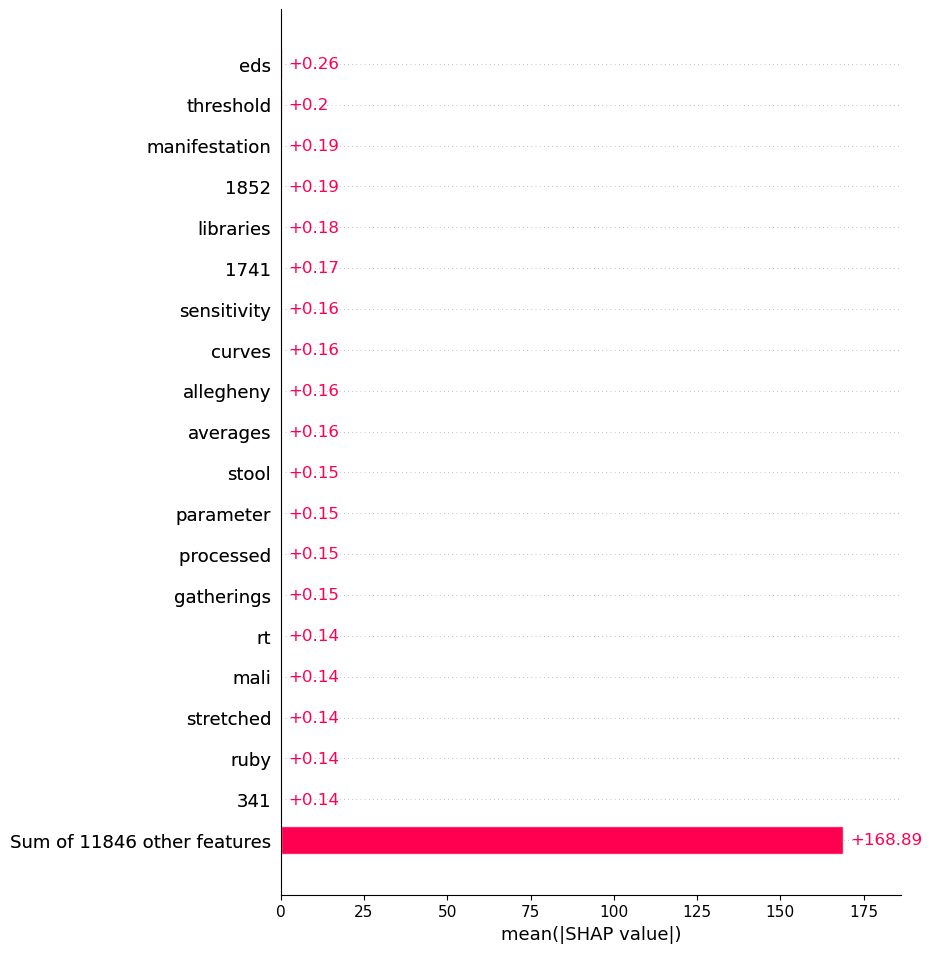

In [14]:
shap.plots.bar(shap_values[:,:,"Fake"].abs.mean(0), max_display=20)

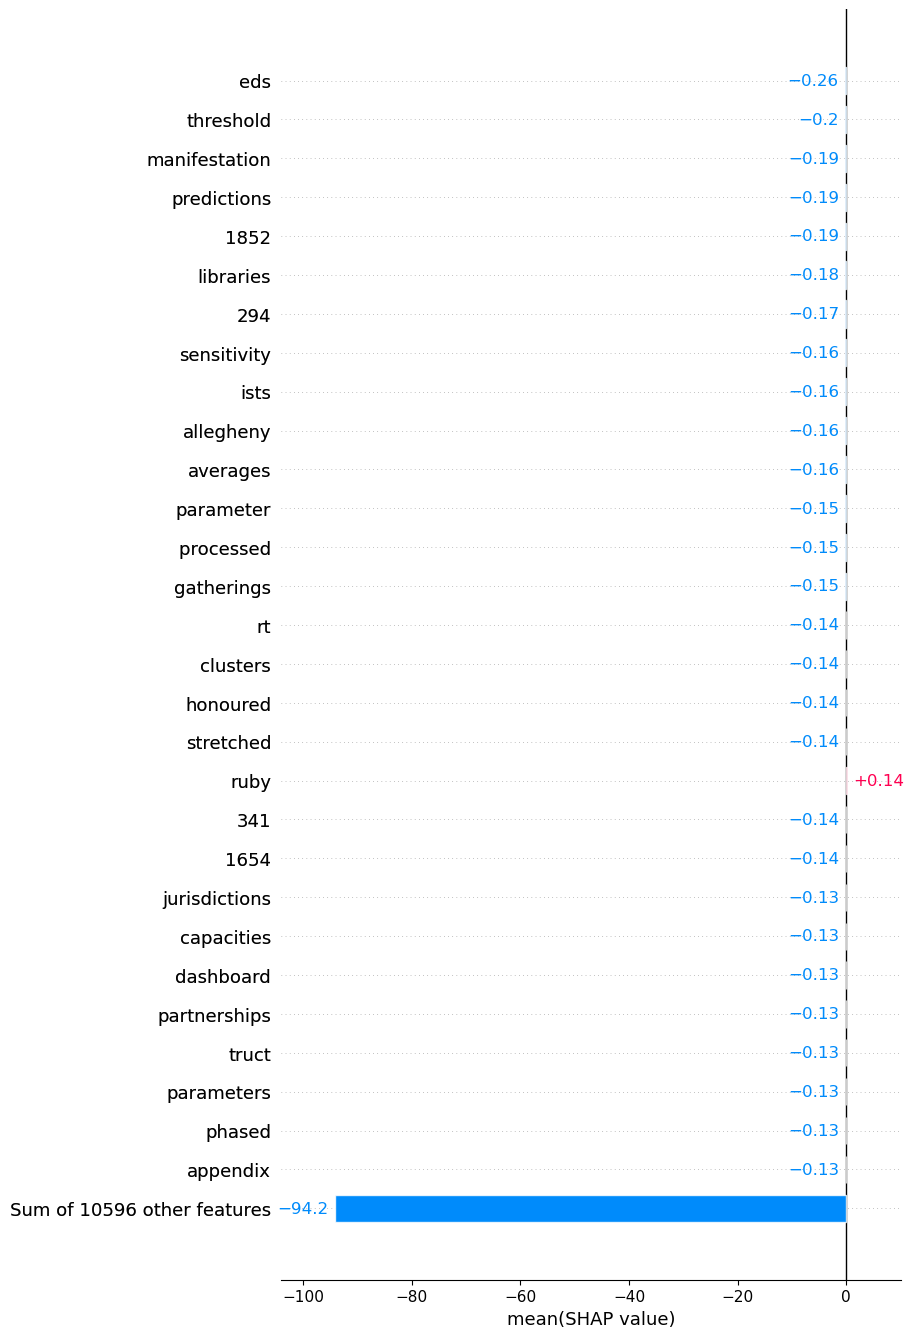

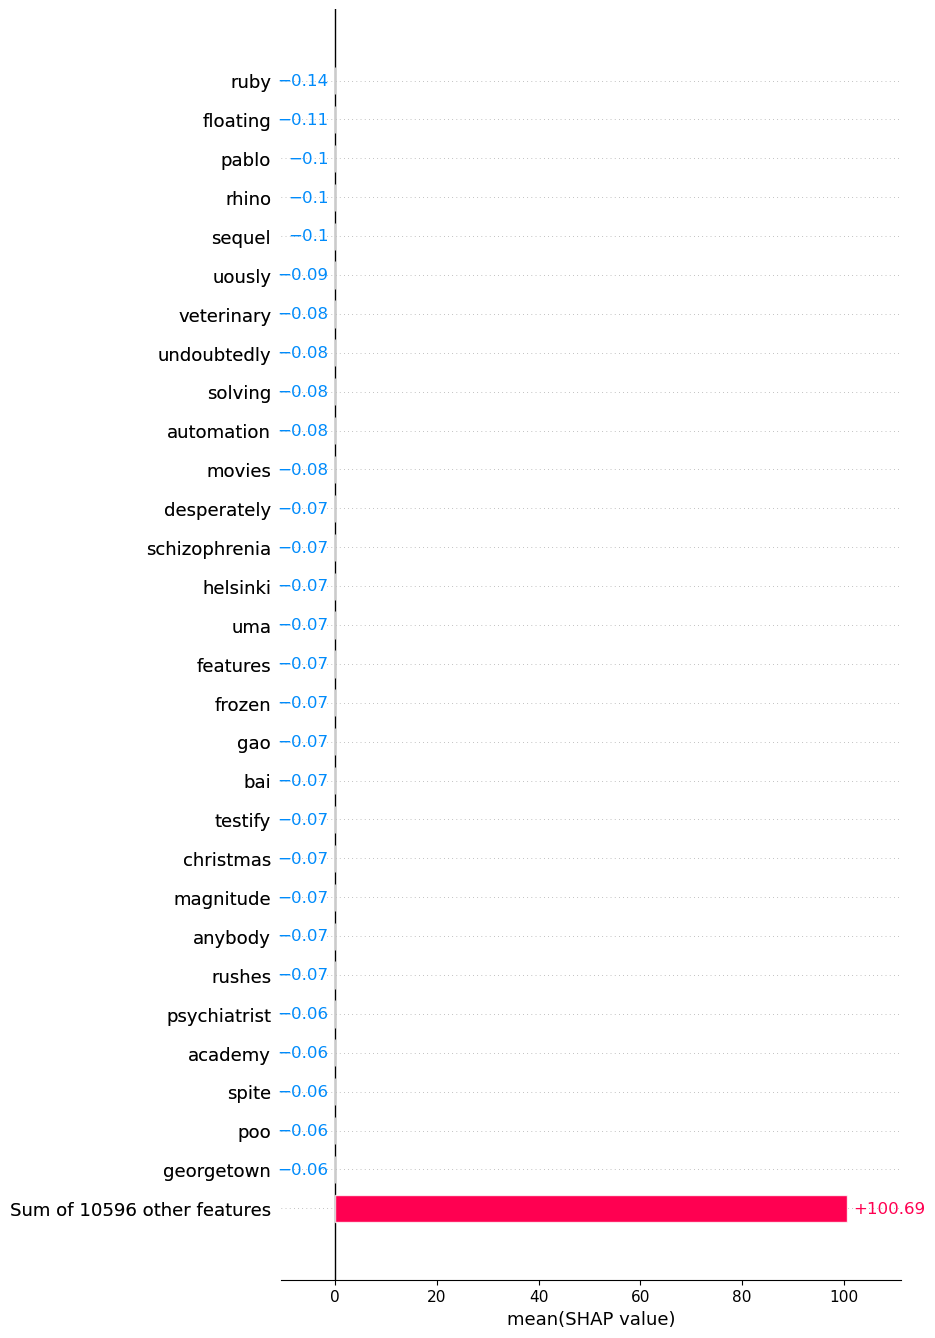

In [125]:
shap.plots.bar(shap_values[:,:,"Fake"].mean(0), max_display=30)
shap.plots.bar(shap_values[:,:,"Real"].mean(0), max_display=30,order=shap.Explanation.argsort)

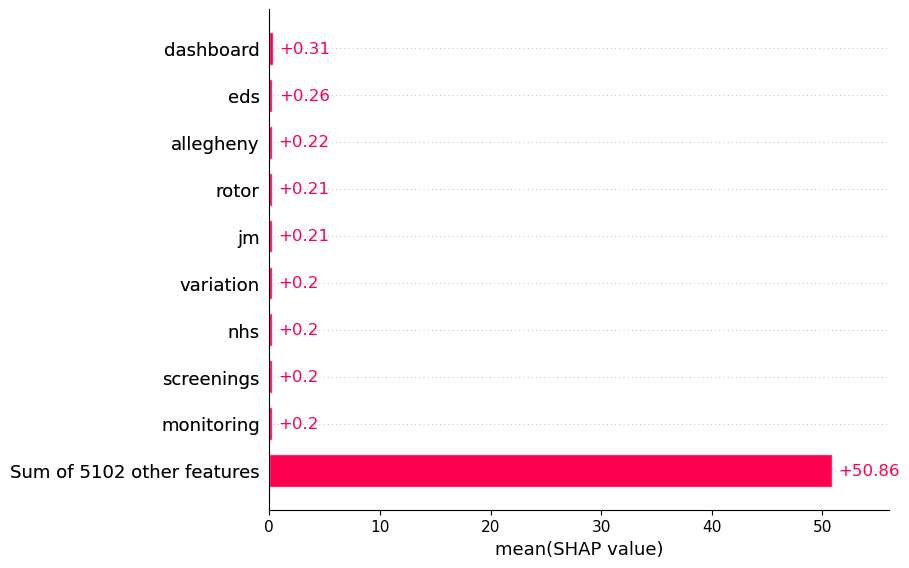

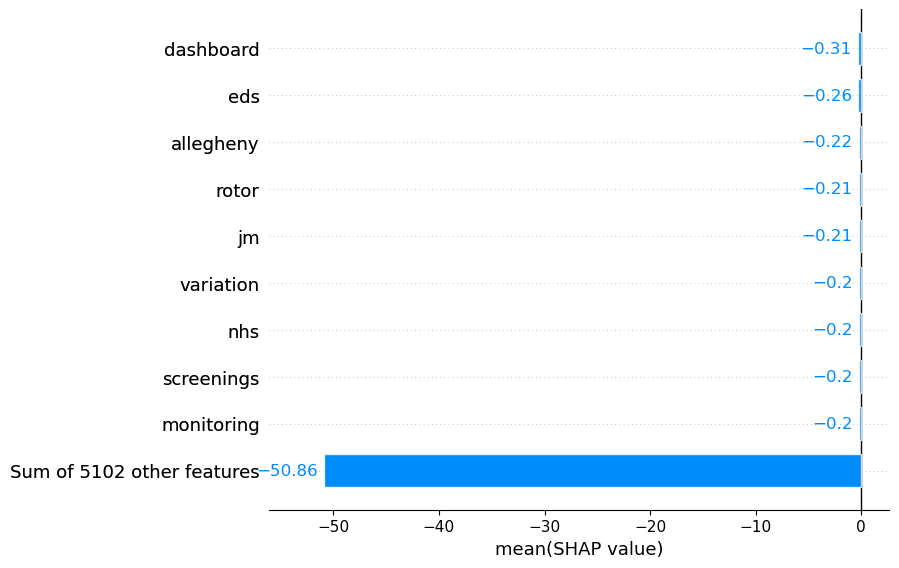

In [65]:
shap.plots.bar(all_train_shap_values1000[:,:,"Real"].mean(0))
shap.plots.bar(all_train_shap_values1000[:,:,"Fake"].mean(0), order=shap.Explanation.argsort)

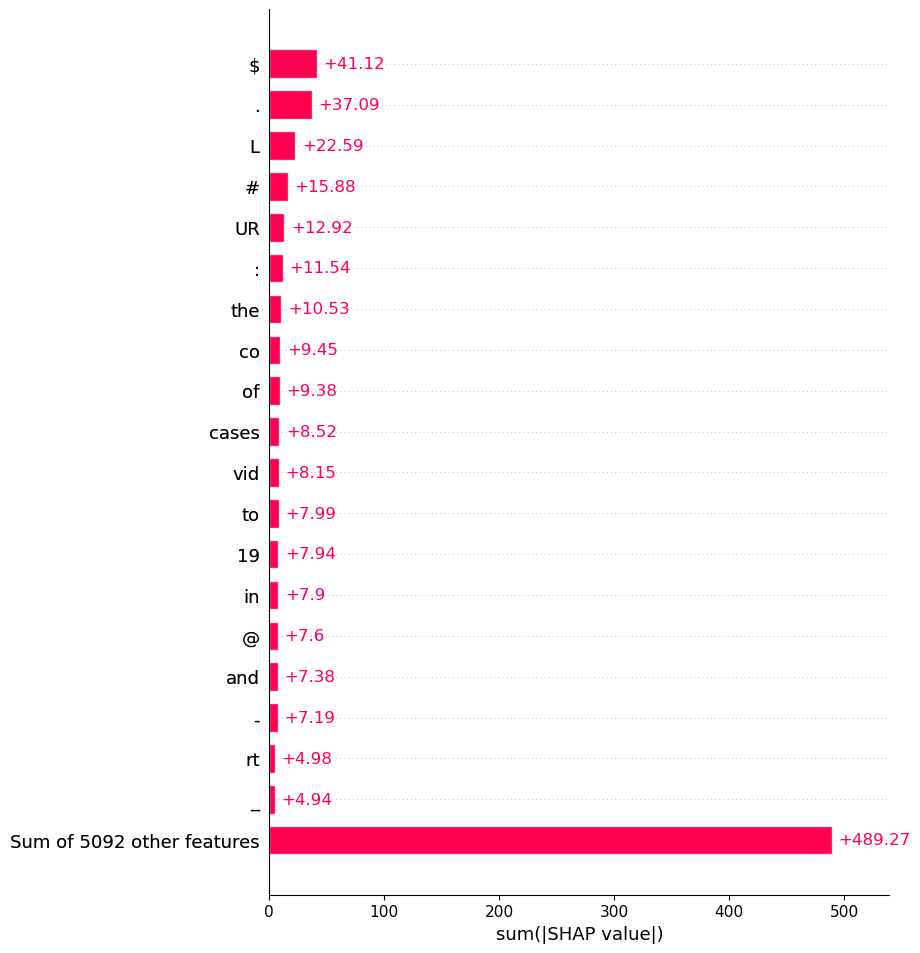

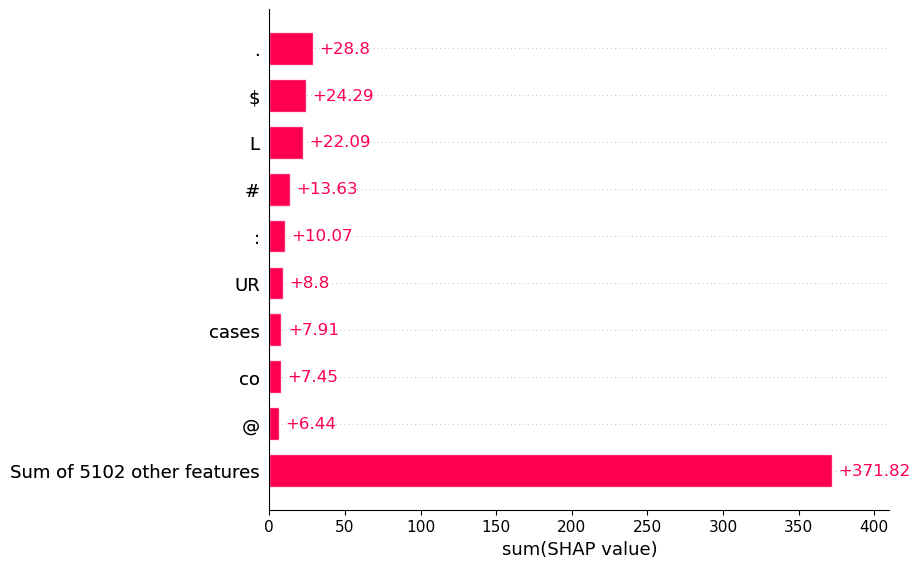

In [56]:
shap.plots.bar(all_train_shap_values1000[:,:,"Fake"].abs.sum(0), max_display=20)

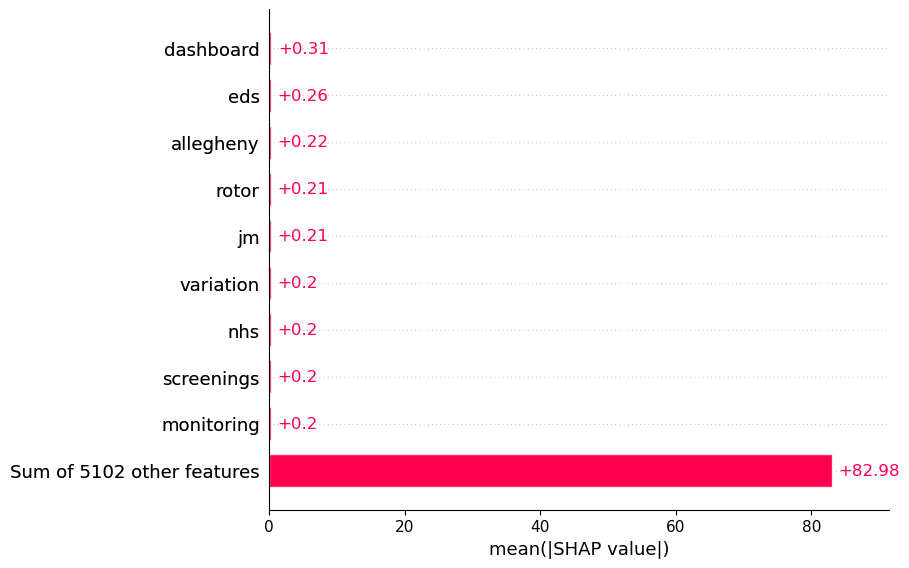

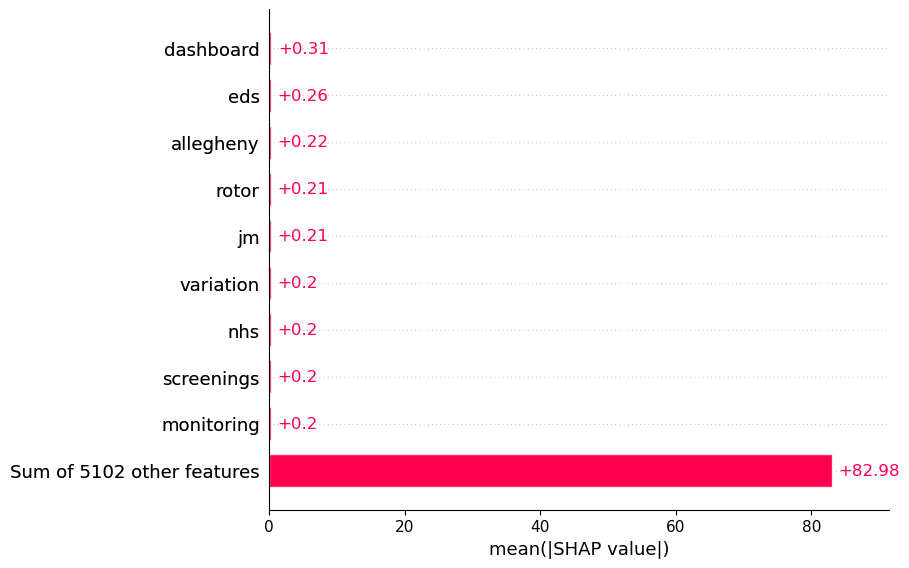

In [45]:
shap.plots.bar(all_train_shap_values1000[:,:,"Fake"].abs.mean(0))
shap.plots.bar(all_train_shap_values1000[:,:,"Real"].abs.mean(0))

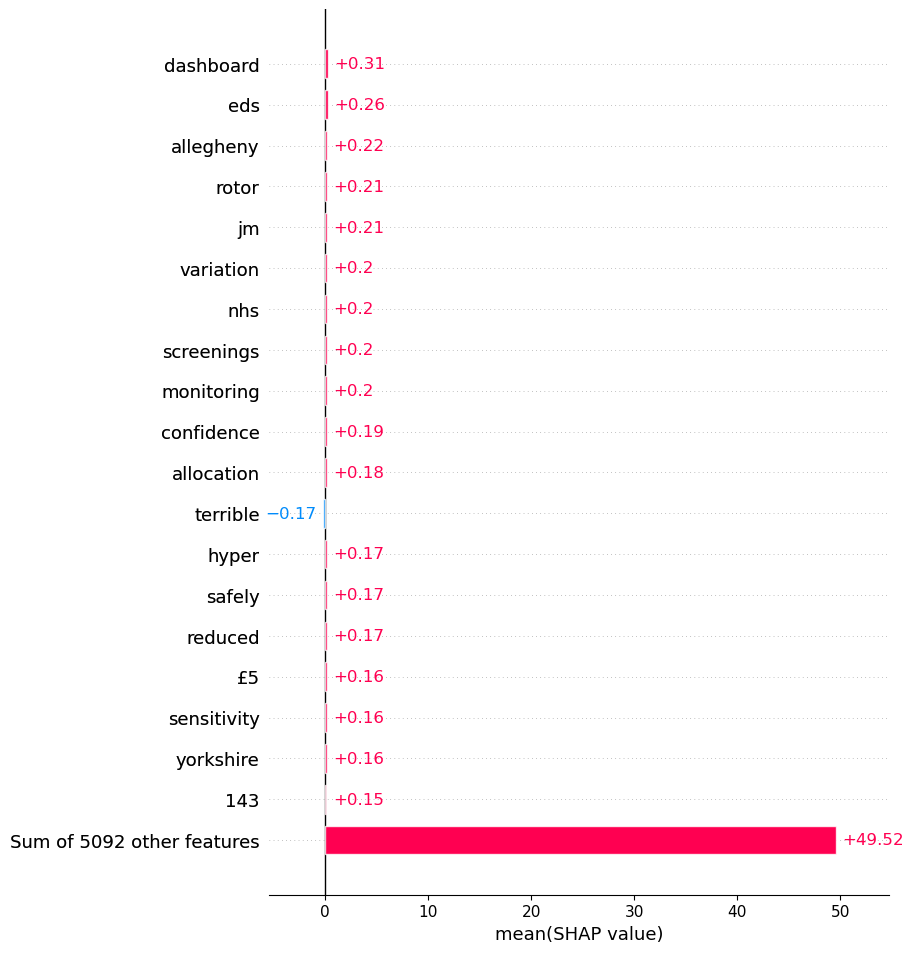

In [ ]:
shap.plots.bar(all_train_shap_values1000[:,:,"Real"].abs.mean(0), max_display=20)

## Tras la mejora del preprocesado

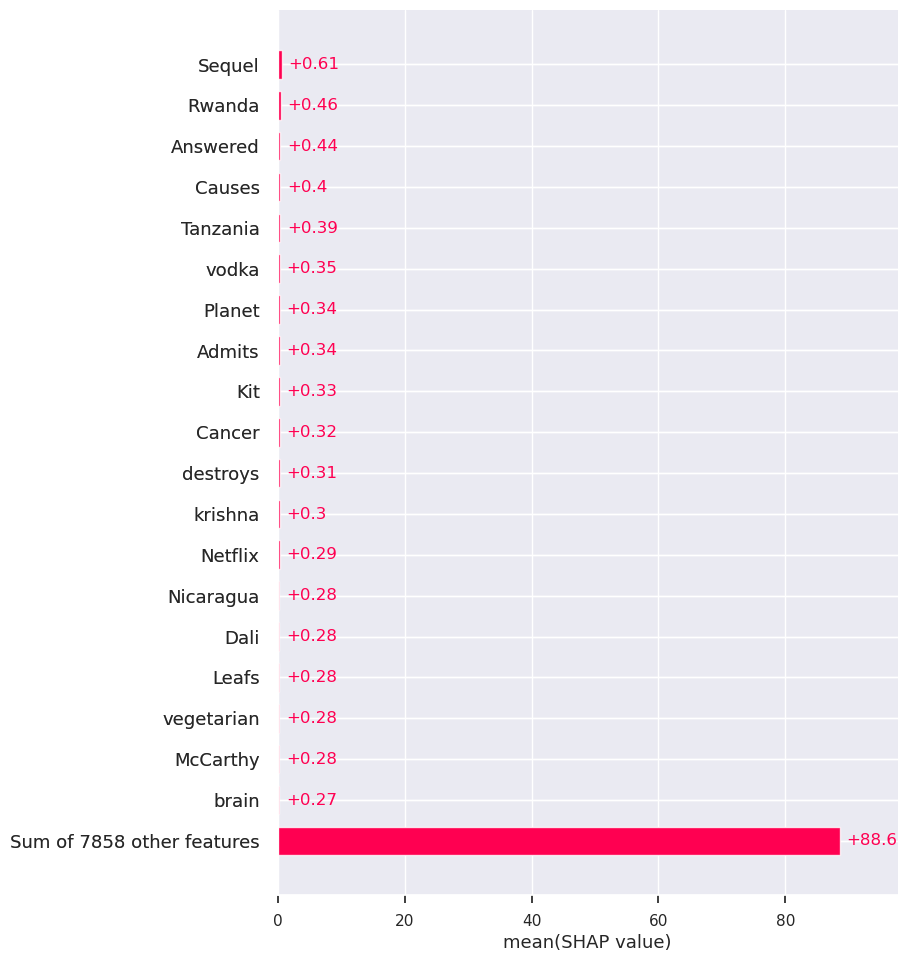

In [10]:
# Las 20 palabras que más determinan una frase como falsa
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Fake"].mean(0), max_display=20)

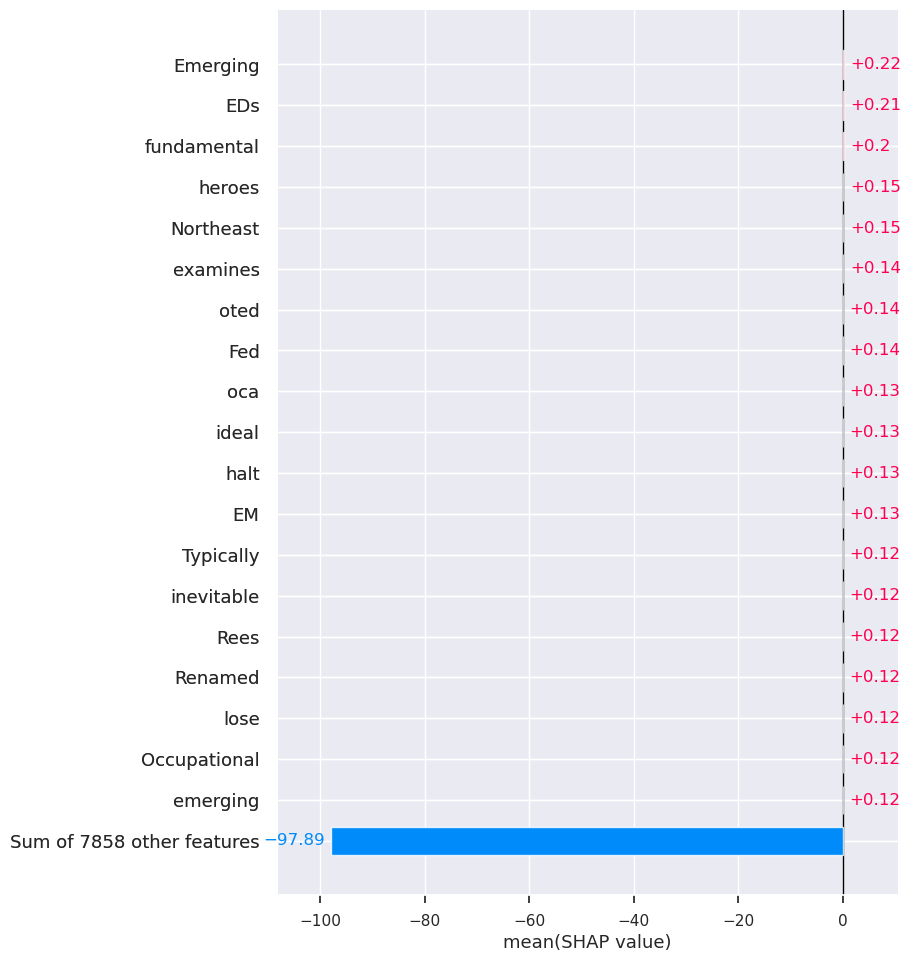

In [19]:
# Las 20 palabras únicas que más hacen verdadera una noticia
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Real"].mean(0), max_display=20, order=shap.Explanation.argsort.flip)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


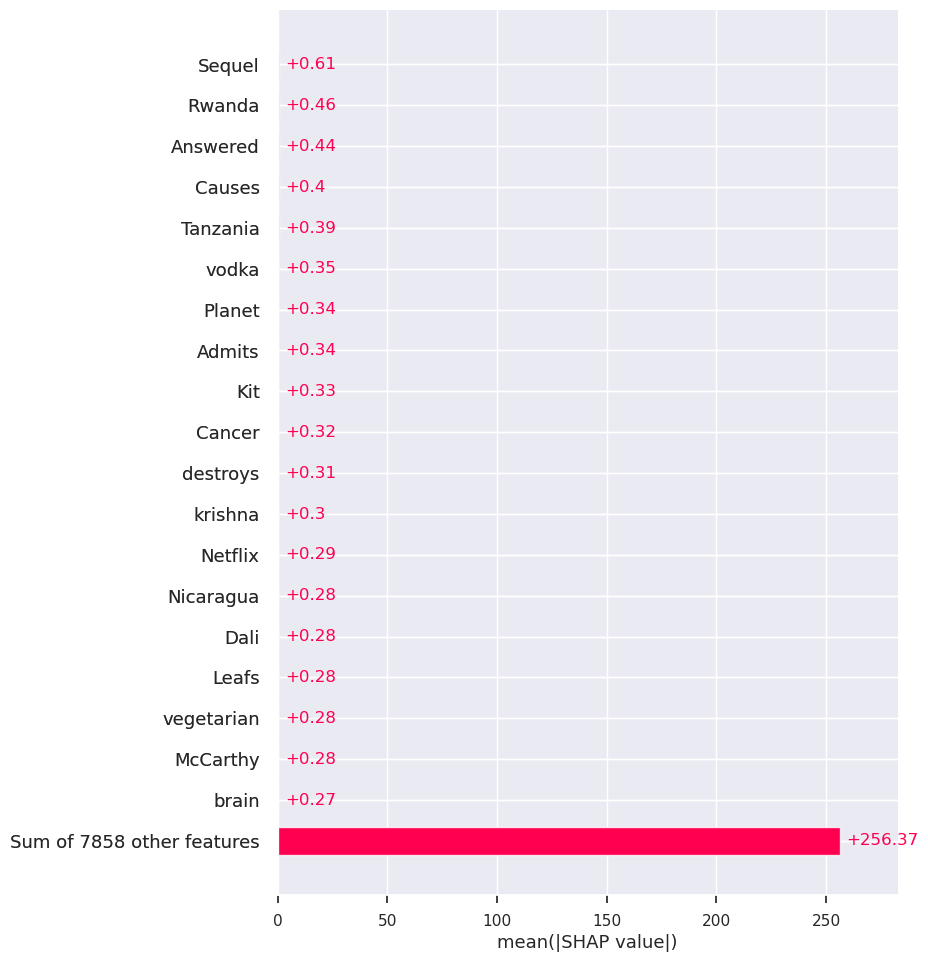

In [20]:
# Las 20 palabras unicas que más determinan una frase 
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Fake"].abs.mean(0), max_display=20)

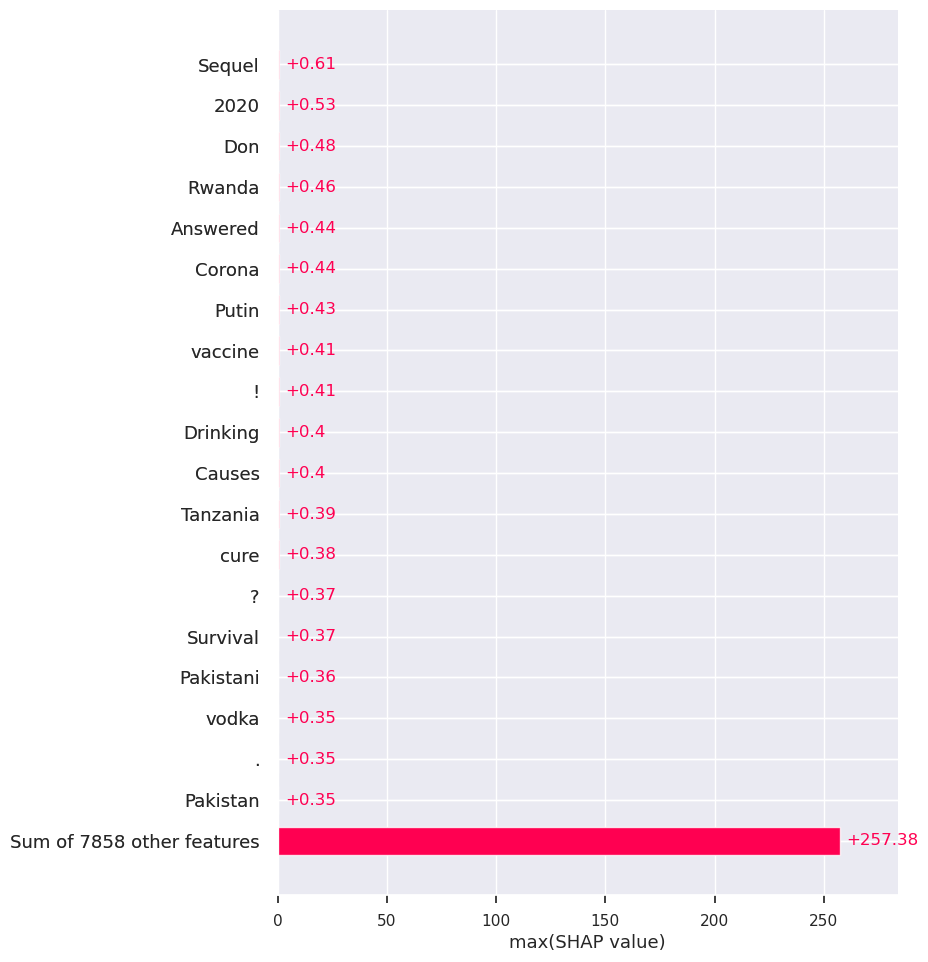

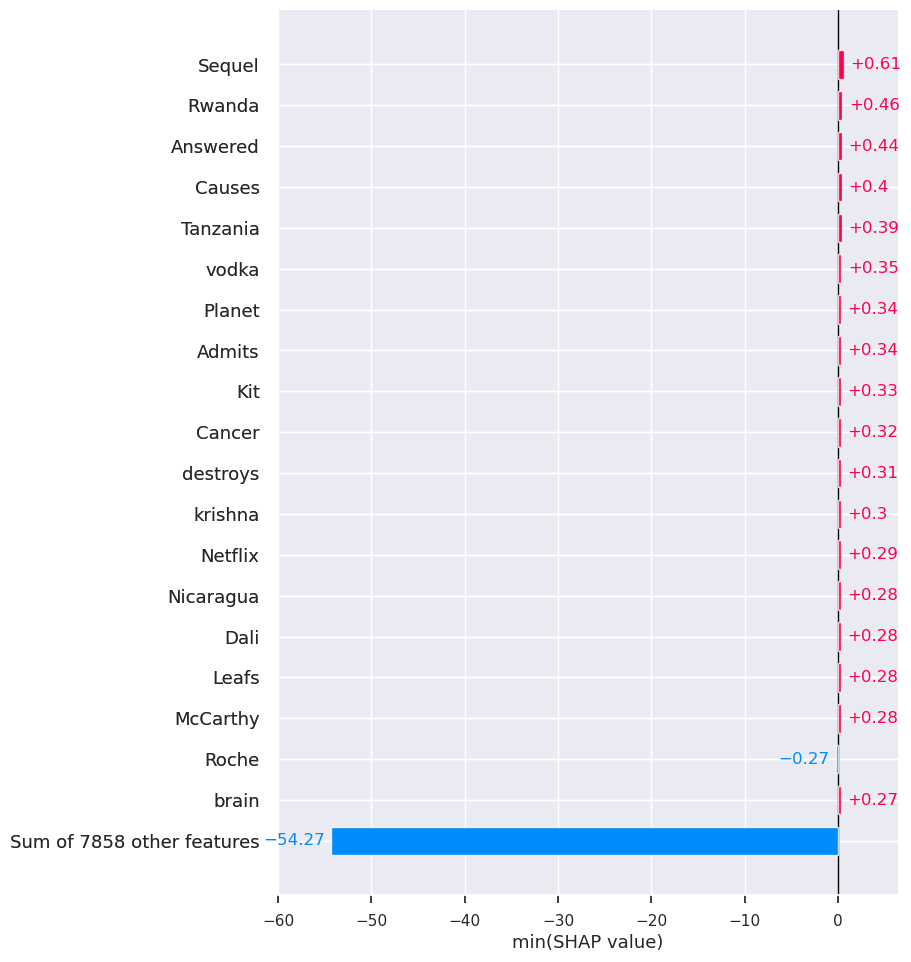

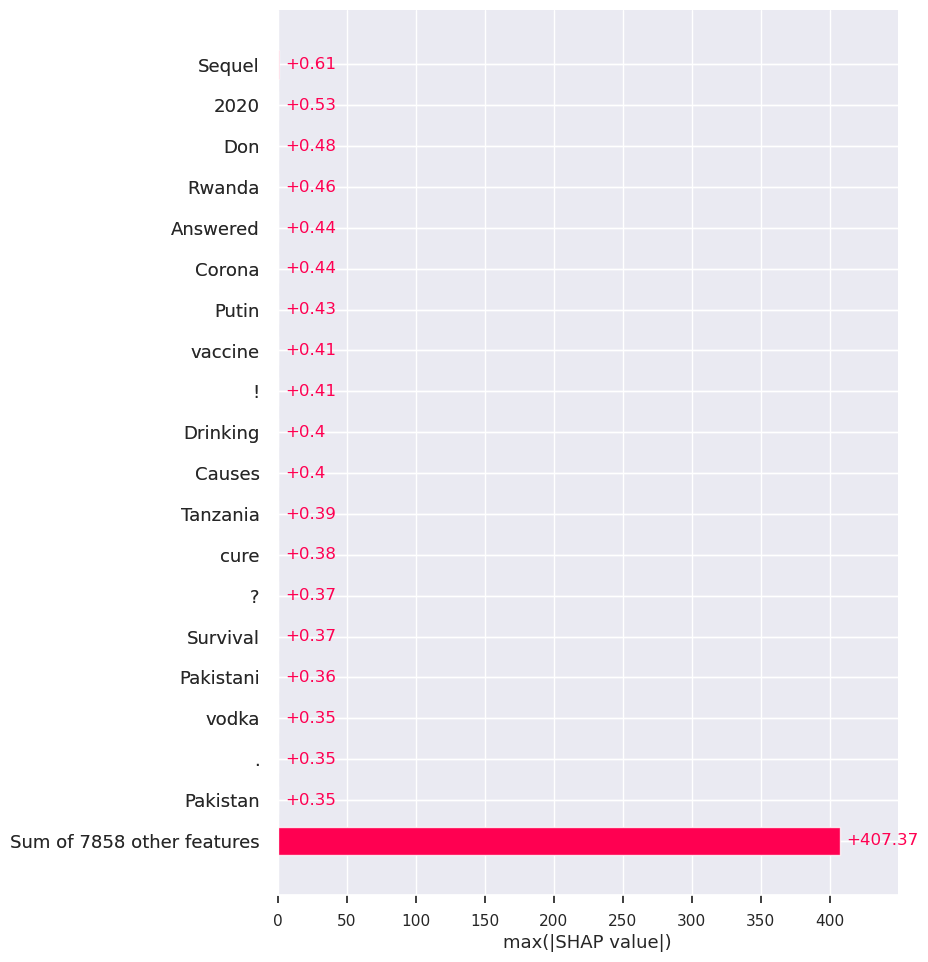

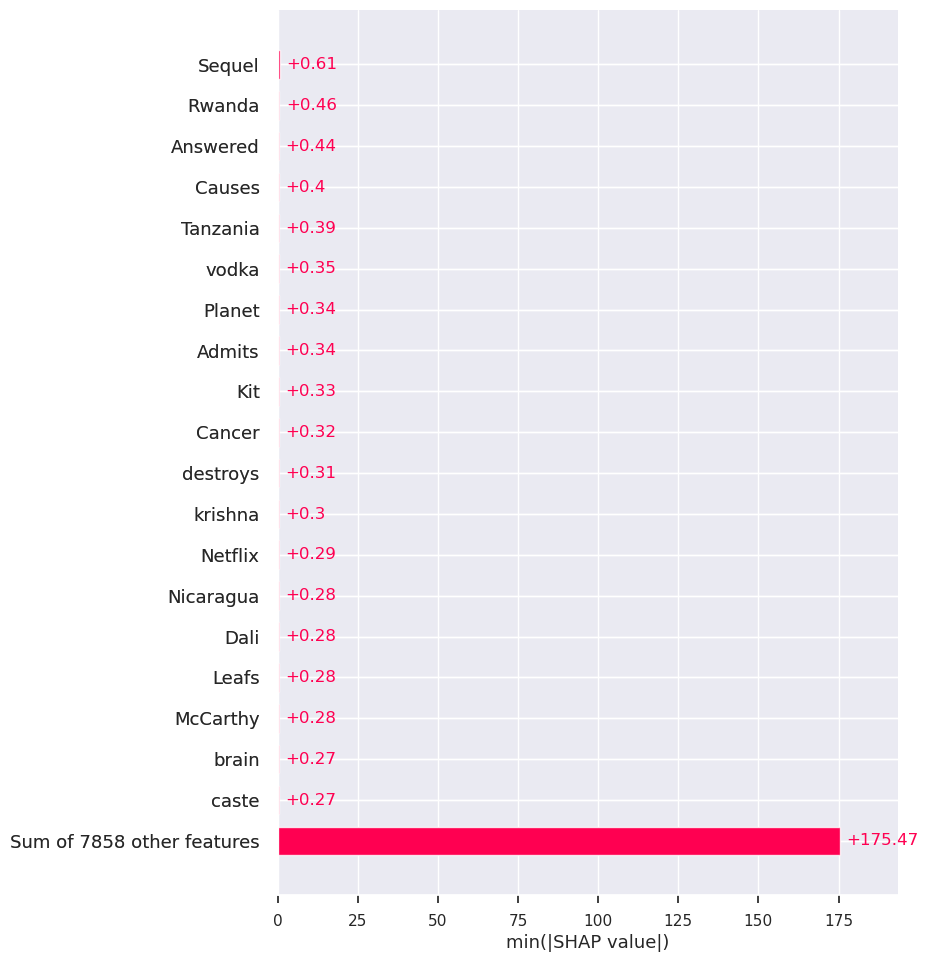

In [21]:
# Las 20 palabras unicas que más determinan una frase 
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Fake"].max(0), max_display=20)
# Las 20 palabras unicas que más determinan una frase 
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Fake"].min(0), max_display=20)
# Las 20 palabras unicas que más determinan una frase 
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Fake"].abs.max(0), max_display=20)
# Las 20 palabras unicas que más determinan una frase 
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Fake"].abs.min(0), max_display=20)

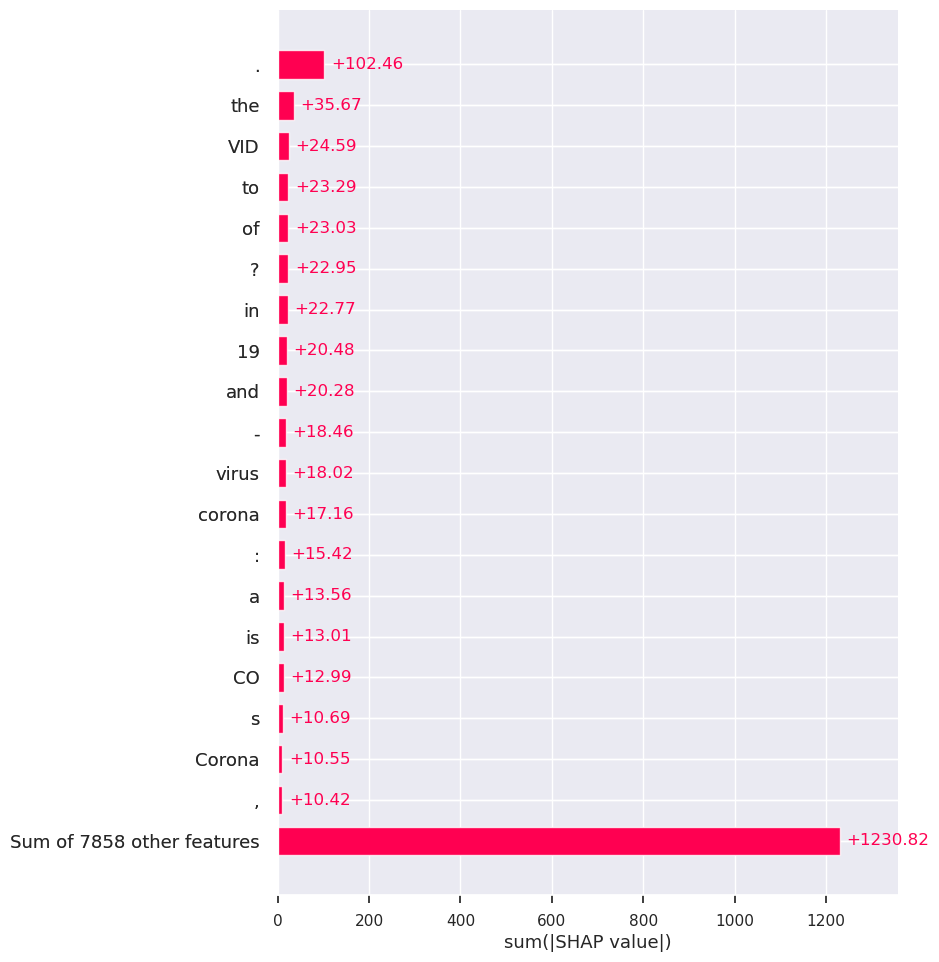

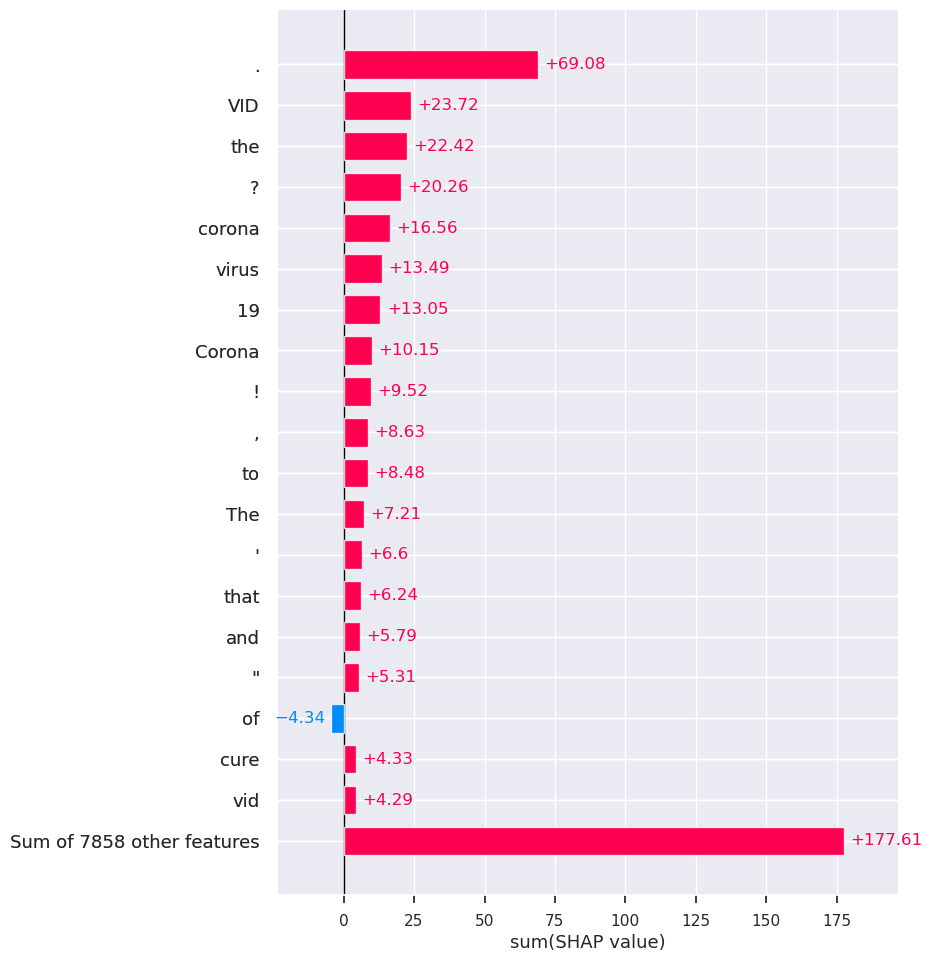

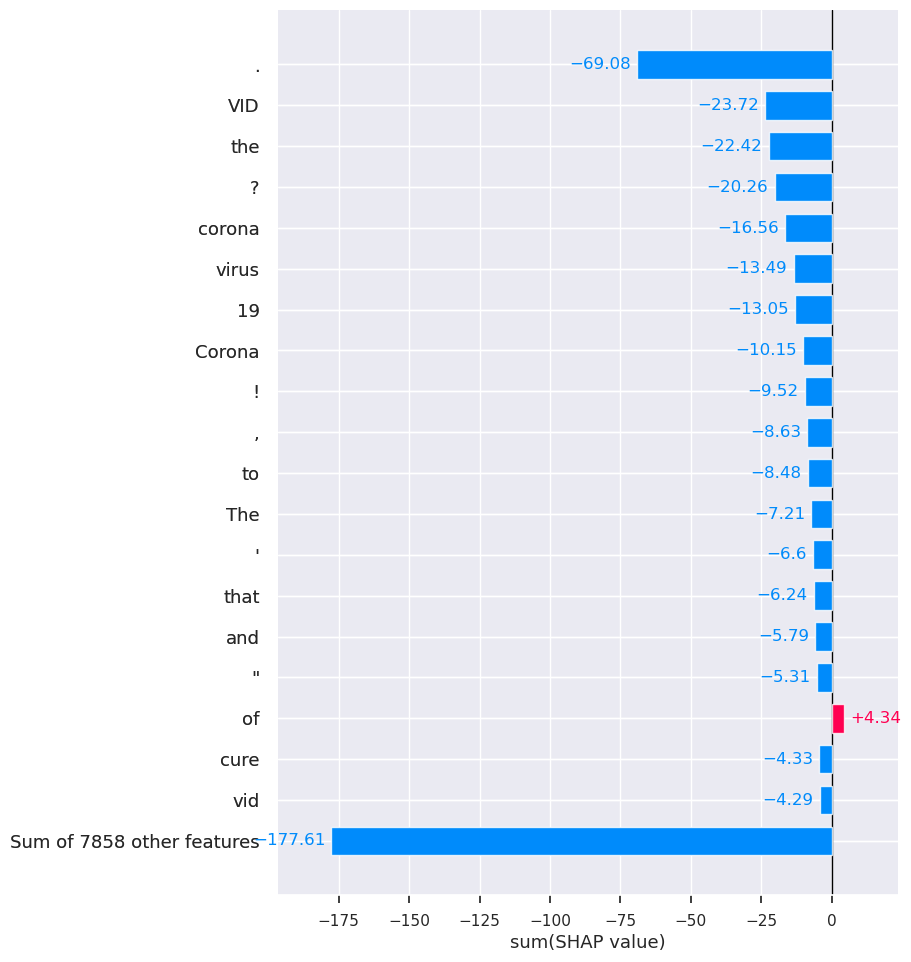

In [22]:
# Las 20 palabras en conjunto que más determinan una frase 
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Fake"].abs.sum(0), max_display=20)
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Fake"].sum(0), max_display=20)
shap.plots.bar(all_train_shap_values2000NEW[:,:,"Real"].sum(0), max_display=20)

Cosas importantes:
* La palabra COVID la cual aparece mucho, está mal procesada
* Aparecen aquí muchos signos de puntuación ya que obviamente en todas las frase hay signos de estos
* Aparecen muchas stopwords (esto no es tf-idf, aquí no quitamos las stopswords)

# Generación de los shap values

Primero escogemos el tokenizador, modelo y texto a utilizar...

In [ ]:
# tokenizer = <>
# model = <>
# texts = <>



Ejemplo:

Preprocesado original

In [14]:
# Cargo el modelo en concreto y el tokenizador
regularization=False
optimizer=Adamax
MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
tokenizer, _ = getTokenizerAndModel(MODEL, model_normalization=False, from_pt = False, regularization=False)
df_train, df_test = cargarDatasetIngles()
train_texts, train_labels, test_texts, test_labels = getTextsLabelsIngles(df_train, df_test)

train_texts = preprocess(train_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=False, cardiff=False, remove_emojis=False)
test_texts  = preprocess(test_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=False, cardiff=False, remove_emojis=False)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


lowercase
python_tokenize
demojize
clean_et
lowercase
python_tokenize
demojize


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


clean_et


The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


Nuevo preprocesado

In [7]:
# Cargo el modelo en concreto y el tokenizador
regularization=False
optimizer=Adamax
MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
tokenizer, _ = getTokenizerAndModel(MODEL, model_normalization=False, from_pt = False, regularization=False)
df_train, df_test = cargarDatasetIngles()
train_texts, train_labels, test_texts, test_labels = getTextsLabelsIngles(df_train, df_test)

pp.set_options(pp.OPT.URL)
train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

2023-06-17 10:13:43.302856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 10:13:44.157874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 10:13:44.158271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 10:13:44.208295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

clean_hashtag
remove_emojis
clean_et
clean_hashtag
remove_emojis
clean_et


The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


In [10]:
df_train[:10].tweet

0    The CDC currently reports 99031 deaths. In gen...
1    States reported 1121 deaths a small rise from ...
2    Politically Correct Woman (Almost) Uses Pandem...
3    #IndiaFightsCorona: We have 1524 #COVID testin...
4    Populous states can generate large case counts...
5    Covid Act Now found "on average each person in...
6    If you tested positive for #COVID19 and have n...
7    Obama Calls Trump’s Coronavirus Response A Cha...
8    ???Clearly, the Obama administration did not l...
9    Retraction—Hydroxychloroquine or chloroquine w...
Name: tweet, dtype: object

In [7]:
train_texts[:10]

['The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.',
 'States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths.',
 'Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag',
 ': We have 1524  testing laboratories in India and as on 25th August 2020 36827520 tests have been done :  DG',
 'Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS NV and SC.',
 'Covid Act Now found "on average each person in Illinois with COVID-19 is infecting 1.11 other people. Data shows that the infection growth rate has declined over time this factors in the stay-at-home order and other restrictions put in place."',
 'If you tested positive for  and 

### Código para generar los shap values

In [15]:
import time

In [16]:
import scipy as sp

def getModelOutputs(x):
    a,b = bert_encode(tokenizer, x, 110)
    outputs = model([a,b])
    return outputs

explainer = shap.Explainer(getModelOutputs,tokenizer,output_names=["Real", "Fake"])

inicio = time.time()
train_shap_values2 = explainer(train_texts[:5])
fin = time.time()
print(fin-inicio)

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 1/5 [00:00<?, ?it/s]The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 3/5 [01:24<00:33, 16.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 4/5 [01:56<00:22, 22.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 5/5 [02:29<00:00, 26.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 6it [03:01, 36.34s/it]                       

181.69539833068848


In [ ]:
model = pickle.load(open("V2_Adamax_multiclass.pkl","rb"))

In [ ]:
model_new_prepro = pickle.load(open("V2_Adamax_multiclass_newprepro.pkl","rb"))

clean_hashtag
remove_emojis
clean_et
clean_hashtag
remove_emojis
clean_et


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


67/67 [==============================] - 18s 263ms/step
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.98857   0.84911   0.91354      1120
           1    0.85654   0.98922   0.91811      1020

    accuracy                        0.91589      2140
   macro avg    0.92255   0.91916   0.91583      2140
weighted avg    0.92564   0.91589   0.91572      2140



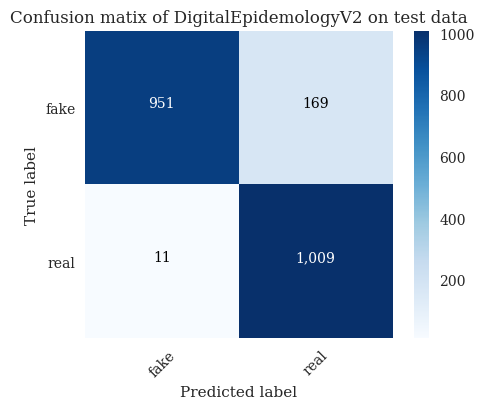

In [12]:
df_train, df_test = cargarDatasetIngles()
train_texts, train_labels, test_texts, test_labels = getTextsLabelsIngles(df_train, df_test)
train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)

pp.set_options(pp.OPT.URL)
train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", normalization=False)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)
pred = getCompleteReportInglesSHAP(model, df_test,test_input_ids, test_attention_masks)

67/67 [==============================] - 17s 260ms/step
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.96046   0.97589   0.96811      1120
           1    0.97305   0.95588   0.96439      1020

    accuracy                        0.96636      2140
   macro avg    0.96676   0.96589   0.96625      2140
weighted avg    0.96646   0.96636   0.96634      2140



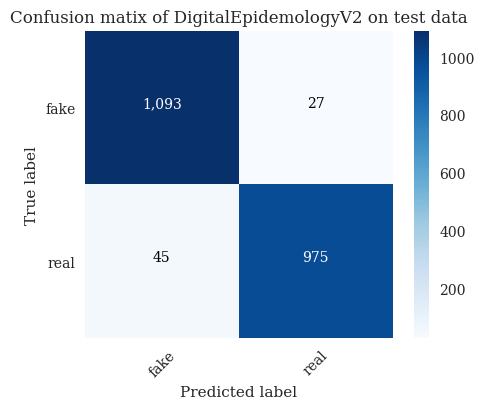

In [13]:
pred = getCompleteReportInglesSHAP(model_new_prepro, df_test,test_input_ids, test_attention_masks)

# NER (Named Entity Recognition)

## Prueba (fuera del artículo)

Primero vemos los resultados con el dataset normal

clean_hashtag
remove_emojis
clean_et
clean_hashtag
remove_emojis
clean_et


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


67/67 [==============================] - 60s 409ms/step
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.96046   0.97589   0.96811      1120
           1    0.97305   0.95588   0.96439      1020

    accuracy                        0.96636      2140
   macro avg    0.96676   0.96589   0.96625      2140
weighted avg    0.96646   0.96636   0.96634      2140



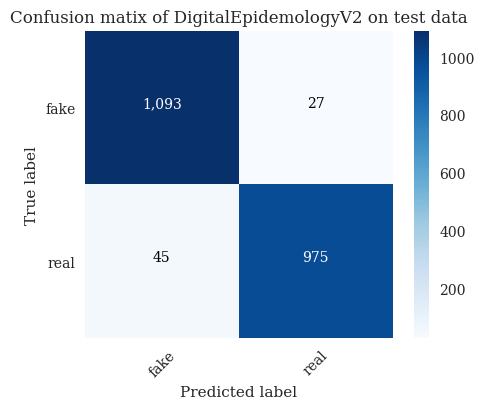

In [8]:
model = pickle.load(open("V2_Adamax softmax2 multiclass new preprocessing.pkl","rb"))

df_train, df_test = cargarDatasetIngles()
train_texts, train_labels, test_texts, test_labels = getTextsLabelsIngles(df_train, df_test)
train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)

pp.set_options(pp.OPT.URL)
train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", normalization=False)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)
pred = getCompleteReportInglesSHAP(model, df_test,test_input_ids, test_attention_masks)

Y ahora evaluamos el rendimiento en el dataset tras aplicar NER

clean_hashtag
remove_emojis
clean_et
clean_hashtag
remove_emojis
clean_et


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


67/67 [==============================] - 27s 408ms/step
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.93504   0.97679   0.95546      1120
           1    0.97320   0.92549   0.94874      1020

    accuracy                        0.95234      2140
   macro avg    0.95412   0.95114   0.95210      2140
weighted avg    0.95323   0.95234   0.95226      2140



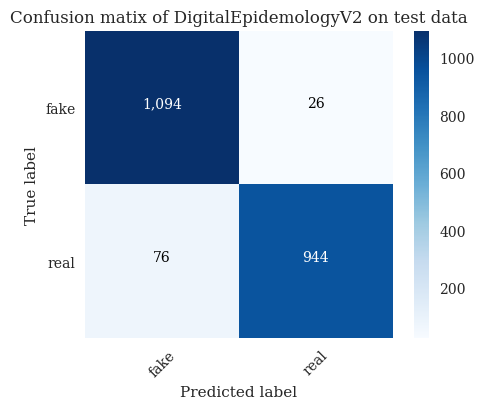

In [12]:
df_train_NER = pd.read_csv("constriantAAAI_train_ner.csv")
df_test_NER = pd.read_csv("constriantAAAI_test_ner.csv")

train_texts, train_labels, test_texts, test_labels = getTextsLabelsInglesNER(df_train_NER,df_test_NER)
train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)

pp.set_options(pp.OPT.URL)
train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", normalization=False)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

pred = getCompleteReportInglesSHAP(model, df_test,test_input_ids, test_attention_masks)

## Entrenamiento con los datos del NER

2023-06-25 11:43:53.295917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 11:43:53.301848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 11:43:53.303786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 11:43:53.306070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

clean_hashtag
remove_emojis
clean_et
clean_hashtag
remove_emojis
clean_et


The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/20


2023-06-25 11:45:07.472586: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x562faffe0ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-25 11:45:07.472642: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-06-25 11:45:07.479542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-25 11:45:07.640157: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/428 [==============================] - 607s 1s/step - loss: 0.2962 - accuracy: 0.8811 - val_loss: 0.1675 - val_accuracy: 0.9398
Epoch 2/20
428/428 [==============================] - 523s 1s/step - loss: 0.1179 - accuracy: 0.9625 - val_loss: 0.1128 - val_accuracy: 0.9614
Epoch 3/20
428/428 [==============================] - 524s 1s/step - loss: 0.0687 - accuracy: 0.9774 - val_loss: 0.1037 - val_accuracy: 0.9638
Epoch 4/20
428/428 [==============================] - 524s 1s/step - loss: 0.0424 - accuracy: 0.9880 - val_loss: 0.0979 - val_accuracy: 0.9685
Epoch 5/20
428/428 [==============================] - 524s 1s/step - loss: 0.0278 - accuracy: 0.9924 - val_loss: 0.1029 - val_accuracy: 0.9690
Epoch 6/20
428/428 [==============================] - 523s 1s/step - loss: 0.0186 - accuracy: 0.9955 - val_loss: 0.1001 - val_accuracy: 0.9725
Epoch 7/20
428/428 [==============================] - 523s 1s/step - loss: 0.0145 - accuracy: 0.9965 - val_loss: 0.0987 - val_accuracy: 0.9725
Epoch 8/20

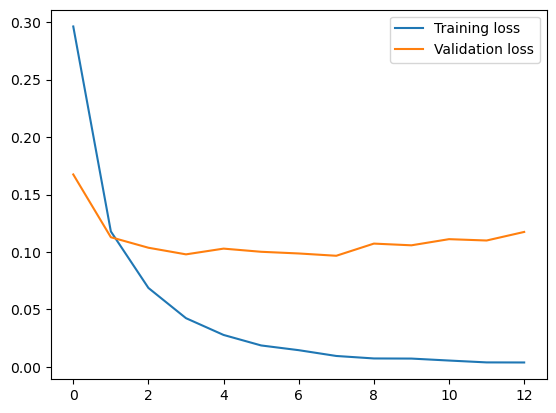

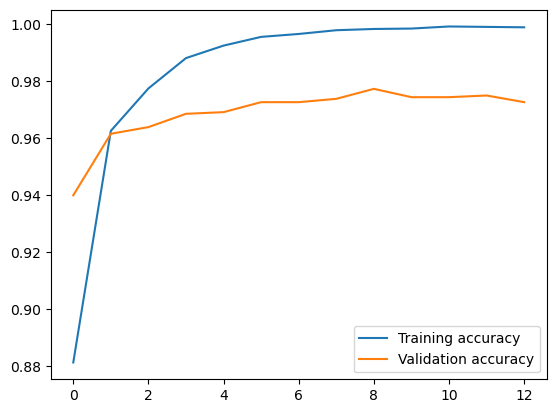

67/67 [==============================] - 60s 790ms/step
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.97404   0.97143   0.97273      1120
           1    0.96872   0.97157   0.97014      1020

    accuracy                        0.97150      2140
   macro avg    0.97138   0.97150   0.97144      2140
weighted avg    0.97150   0.97150   0.97150      2140



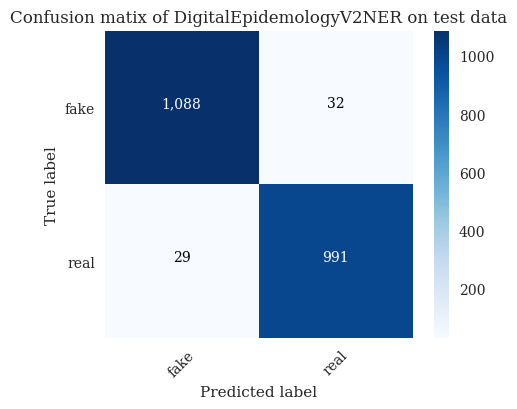

In [7]:
model_ConstraintAAAI_NER = DigitalEpidemologyV2NER(regularization=False,optimizer=Adamax)

In [ ]:
pickle.dump(model_ConstraintAAAI_NER,open("model_ConstraintAAAI_NER_newTokens.pkl","wb"))

## Prueba con el propio dataset tras aplicar NER

clean_hashtag
remove_emojis
clean_et
clean_hashtag
remove_emojis
clean_et


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


67/67 [==============================] - 54s 802ms/step
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.96215   0.97589   0.96897      1120
           1    0.97311   0.95784   0.96542      1020

    accuracy                        0.96729      2140
   macro avg    0.96763   0.96687   0.96719      2140
weighted avg    0.96737   0.96729   0.96728      2140



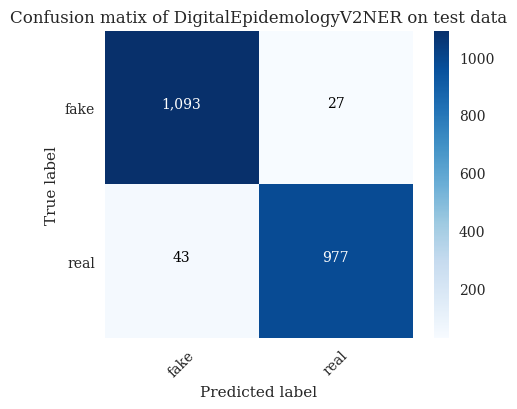

In [9]:
df_train_NER = pd.read_csv("constriantAAAI_train_ner.csv")
df_test_NER = pd.read_csv("constriantAAAI_test_ner.csv")

train_texts, train_labels, test_texts, test_labels = getTextsLabelsInglesNER(df_train_NER,df_test_NER)
train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)

pp.set_options(pp.OPT.URL)
train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", normalization=False)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

pred = getCompleteReportInglesSHAP(model_ConstraintAAAI_NER, df_test,test_input_ids, test_attention_masks)

## Prueba con un dataset externo

In [4]:
df_externo_test = pd.read_csv("Cross-SEAN/test.txt", sep='\t', names=["label", "tweet"])
df_externo_test

,label,tweet
0,0,media briefing on covid with
1,1,new johnson amp johnson says its covid vacci...
2,0,i hope a lot of people read this thread
3,1,what if coronavirus part of that lysol can t...
4,1,thailand claiming they have good result of m...
...,...,...
769,0,currently there is no vaccine for covid or a...
770,1,poor creator of us bioweapons act says coron...
771,1,if black ppl immune to the coronavirus houst...
772,1,we should think about this it might be helpf...


In [ ]:
model_ConstraintAAAI_NER = pickle.load(open("model_ConstraintAAAI_NER_newTokens.pkl","rb"))

In [4]:
pp.set_options(pp.OPT.URL)

test_texts = list(df_externo_test.tweet)
# train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", normalization=False)
num_special_tokens = tokenizer.add_tokens(["LOC", "MISC", "ORG", "PER"])
# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
# train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

pred = getCompleteReportInglesSHAP(model_ConstraintAAAI_NER, df_externo_test,test_input_ids, test_attention_masks)

NameError: name 'df_externo_test' is not defined

In [ ]:
model_ConstraintAAAI_NER_Antiguo = pickle.load(open("model_ConstraintAAAI_NER.pkl","rb"))

In [6]:
pp.set_options(pp.OPT.URL)

test_texts = list(df_externo_test.tweet)
# train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)

tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", normalization=False)
num_special_tokens = tokenizer.add_tokens(["LOC", "MISC", "ORG", "PER"])
# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
# train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

pred = getCompleteReportInglesSHAP(model_ConstraintAAAI_NER_Antiguo, df_externo_test,test_input_ids, test_attention_masks)

NameError: name 'df_externo_test' is not defined

## Con el modelo del TFG

In [ ]:
pp.set_options(pp.OPT.URL)
modelTFG = pickle.load(open("V2_Adamax_multiclass_2006.pkl","rb"))

test_texts = list(df_externo_test.tweet)
# train_texts = preprocess(train_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
# test_texts  = preprocess(test_texts, lowercase=False, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=True)
test_texts = preprocess(test_texts, lowercase=True, python_tokenize=True, demojize=True, clean_hashtag=False, cardiff=False, remove_emojis=False)

tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", normalization=False)
# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

sentence_length = 110
# train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)

pred = getCompleteReportInglesSHAP(modelTFG, df_externo_test,test_input_ids, test_attention_masks)

## Obtención del dataset con NER

In [14]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer,aggregation_strategy="simple")
example = "???Covid is never going away! This is the beach today in Raleigh, North Carolina.??�"

ner_results = nlp(example)
print(ner_results)

[{'entity_group': 'PER', 'score': 0.9860612, 'word': 'Co', 'start': 3, 'end': 5}, {'entity_group': 'LOC', 'score': 0.99730337, 'word': 'Raleigh', 'start': 57, 'end': 64}, {'entity_group': 'LOC', 'score': 0.99890494, 'word': 'North Carolina', 'start': 66, 'end': 80}]


In [19]:
example = "Covid-19"

ner_results = nlp(example)
print(ner_results)

[{'entity_group': 'ORG', 'score': 0.9675038, 'word': 'Covid', 'start': 0, 'end': 5}]


In [15]:
import re


def isCovid(word):
    if word.lower() in ["covid","corona", "coronavirus", "corona", "covid19", "covid-19"]:
        return True
    else:
        return False

def replace_exact_word(text, old_word, new_word):
    pattern = r'\b{}\b'.format(re.escape(old_word))
    replaced_text = re.sub(pattern, new_word, text)
    return replaced_text

def replace_ner(ner_model,text):
    ner_results = ner_model(text)
    
    for ner in ner_results:
        if not isCovid(ner["word"]):
            text = replace_exact_word(text,ner["word"], ner["entity_group"])
        
    return text

In [ ]:
df = df_train_NER

tweet_ner = []
for index, row in df.iterrows():
    tweet_ner.append(replace_ner(nlp,row["tweet"]))
    
df["tweet_ner"] = tweet_ner

df.to_csv("constriantAAAI_train_ner_NEW.csv")



In [21]:
df = df_test_NER
tweet_ner = []
for index, row in df.iterrows():
    tweet_ner.append(replace_ner(nlp,row["tweet"]))
    
df["tweet_ner"] = tweet_ner

df.to_csv("constriantAAAI_test_ner_NEW.csv")